In [ ]:
#| hide
from nbdev import *

# LAMMPS Tutorial
> This example uses ASAP3/LAMMPS potential to calculate forces and energies. This is a free calculator which can be installed either from conda-forge or separately. At the moment conda-forge version supports only linux environment. You can run this tutorial on binder: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gl/jochym%2Fhecss/devel?labpath=01_LAMMPS_Tutorial.ipynb).

In [ ]:
#| asap
from hecss import HECSS
from hecss.monitor import plot_stats
from hecss.util import select_asap_model, create_asap_calculator
from ase.build import bulk

In [ ]:
#| asap
model = select_asap_model('SiC')
print(f'Using potential model: {model}')

Using potential model: MEAM_LAMMPS_KangEunJun_2014_SiC__MO_477506997611_000


In [ ]:
#| asap
sys_size = '3x3x3'
sc = [int(v) for v in sys_size.split('x')]

In [ ]:
#| asap
cryst = bulk('SiC', crystalstructure='zincblende',
                 a=4.38120844, cubic=True).repeat(tuple(sc))
cryst.set_calculator(create_asap_calculator(model))

In [ ]:
#| asap
hecss = HECSS(cryst, lambda : create_asap_calculator(model), pbar=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

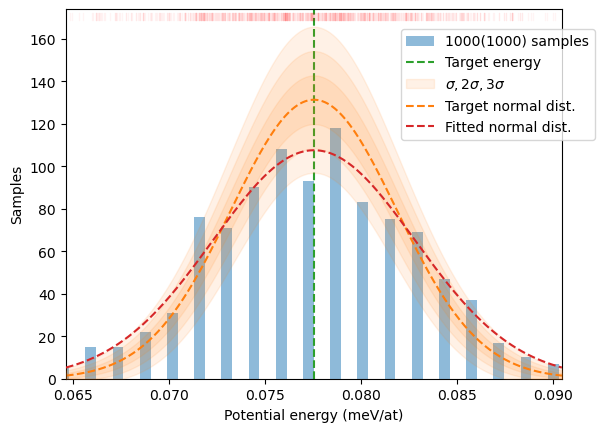

In [ ]:
#| asap
T = 600
N = 1_000
samples = hecss.sample(T,N)
plot_stats(samples, T)

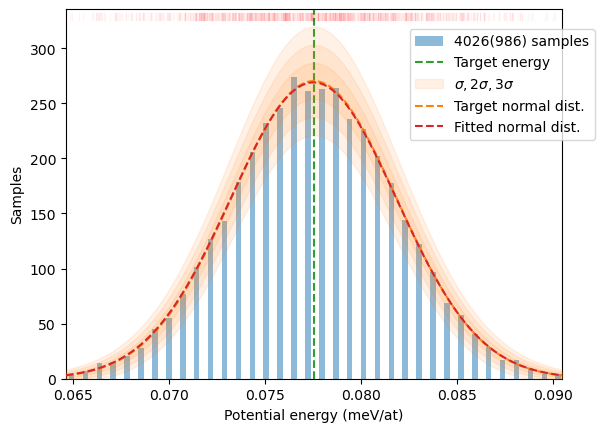

In [ ]:
#| asap
distrib = hecss.generate(samples, T)
plot_stats(distrib, T)